In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import yaml
from matplotlib import pyplot as plt

In [2]:
with open("config.yaml", "r") as stream:
    config = yaml.safe_load(stream)
    model_kwargs = config['model']
    features_config = config['features']

In [3]:
data = pd.read_csv("data.csv")
data.Appliances = np.log(data.Appliances)
data[features_config['features_to_normalize']] = data[features_config['features_to_normalize']].apply(lambda x : x/100)
data.date = pd.to_datetime(data.date)
data = data.set_index("date")

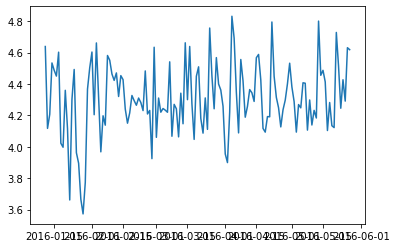

In [4]:
data_plot = data.resample('1D').mean().reset_index()[['date', 'Appliances']]
plt.plot(data_plot.date, data_plot.Appliances)

In [5]:
data[features_config['optimization_features']].describe()

,T1,T2,T3
count,19735.000000,19735.000000,19735.000000
mean,21.686571,20.341219,22.267611
std,1.606066,2.192974,2.006111
min,16.790000,16.100000,17.200000
25%,20.760000,18.790000,20.790000
50%,21.600000,20.000000,22.100000
75%,22.600000,21.500000,23.290000
max,26.260000,29.856667,29.236000


In [6]:
beggining_test = pd.Timestamp(data_plot.date.sort_values().iloc[int(len(data_plot.date)*0.75)])

In [7]:
#data = data.set_index("date")
data_train, data_test = data[data.index < beggining_test], data[data.index >= beggining_test]


In [8]:
data_train.columns

Index(['Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [9]:
features_list = features_config['raw_features']+features_config['features_to_normalize']+features_config['optimization_features']
X_train, y_train = data_train[features_list], data_train[features_config['regression_feature']]
X_test, y_test = data_test[features_list], data_test[features_config['regression_feature']]



In [10]:
X_train

,lights,T_out,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T4,T5,T6,T7,...,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out,T1,T2,T3
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,30,6.600000,733.500000,7.000000,63.000000,5.300000,19.000000,17.166667,7.026667,17.200000,...,0.455667,0.552000,0.842567,0.416267,0.489000,0.455300,0.920000,19.890000,19.200000,19.790000
2016-01-11 17:10:00,30,6.483333,733.600000,6.666667,59.166667,5.200000,19.000000,17.166667,6.833333,17.200000,...,0.459925,0.552000,0.840633,0.415600,0.488633,0.455600,0.920000,19.890000,19.200000,19.790000
2016-01-11 17:20:00,30,6.366667,733.700000,6.333333,55.333333,5.100000,18.926667,17.166667,6.560000,17.200000,...,0.458900,0.550900,0.831567,0.414333,0.487300,0.455000,0.920000,19.890000,19.200000,19.790000
2016-01-11 17:30:00,40,6.250000,733.800000,6.000000,51.500000,5.000000,18.890000,17.166667,6.433333,17.133333,...,0.457233,0.550900,0.834233,0.412900,0.485900,0.454000,0.920000,19.890000,19.200000,19.790000
2016-01-11 17:40:00,40,6.133333,733.900000,5.666667,47.666667,4.900000,18.890000,17.200000,6.366667,17.200000,...,0.455300,0.550900,0.848933,0.412300,0.485900,0.454000,0.920000,19.890000,19.200000,19.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-22 23:10:00,0,9.883333,756.916667,5.000000,30.833333,5.216667,22.500000,21.100000,9.830000,21.600000,...,0.352000,0.631667,0.216000,0.322771,0.438267,0.383267,0.726667,22.700000,20.633333,24.890000
2016-04-22 23:20:00,0,9.766667,756.933333,5.000000,32.666667,5.033333,22.500000,21.100000,9.733333,21.557143,...,0.352000,0.615000,0.220300,0.322900,0.439633,0.384667,0.723333,22.700000,20.600000,24.890000
2016-04-22 23:30:00,0,9.650000,756.950000,5.000000,34.500000,4.850000,22.478000,21.100000,9.533333,21.500000,...,0.351780,0.598333,0.240300,0.322900,0.441633,0.386267,0.720000,22.700000,20.600000,24.890000


In [11]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [12]:
X_train

,lights,T_out,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T4,T5,T6,T7,...,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out,T1,T2,T3
0,3.003298,0.164457,-2.748417,1.037009,1.911966,0.699670,-0.719206,-1.331054,0.178493,-1.442542,...,1.496491,0.399260,0.712553,1.249768,1.105490,0.960114,0.783827,-1.003962,-0.296323,-1.150200
1,3.003298,0.136787,-2.735909,0.908932,1.609488,0.671867,-0.719206,-1.331054,0.137869,-1.442542,...,1.596837,0.399260,0.705557,1.236532,1.098530,0.967710,0.783827,-1.003962,-0.296323,-1.150200
2,3.003298,0.109117,-2.723402,0.780855,1.307011,0.644065,-0.767045,-1.331054,0.080436,-1.442542,...,1.572683,0.387051,0.672747,1.211384,1.073223,0.952517,0.783827,-1.003962,-0.296323,-1.150200
3,4.178887,0.081447,-2.710895,0.652777,1.004534,0.616262,-0.790965,-1.331054,0.053821,-1.484418,...,1.533409,0.387051,0.682397,1.182927,1.046651,0.927196,0.783827,-1.003962,-0.296323,-1.150200
4,4.178887,0.053777,-2.698387,0.524700,0.702056,0.588460,-0.790965,-1.305526,0.039812,-1.442542,...,1.487850,0.387051,0.735593,1.171015,1.046651,0.927196,0.783827,-1.003962,-0.296323,-1.150200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14725,-0.523468,0.943166,0.180398,0.268545,-0.626213,0.676501,1.564015,1.681262,0.767533,1.321331,...,-0.946380,1.283480,-1.554849,-0.606453,0.142550,-0.863855,-0.709477,1.267475,0.640832,2.231358
14726,-0.523468,0.915496,0.182483,0.268545,-0.481550,0.625530,1.564015,1.681262,0.747222,1.294410,...,-0.946380,1.098496,-1.539288,-0.603901,0.168490,-0.828405,-0.735223,1.267475,0.619037,2.231358
14727,-0.523468,0.887826,0.184567,0.268545,-0.336887,0.574558,1.549663,1.681262,0.705197,1.258516,...,-0.951564,0.913513,-1.466913,-0.603901,0.206451,-0.787892,-0.760970,1.267475,0.619037,2.231358
14728,-0.523468,0.860156,0.186652,0.268545,-0.192224,0.523587,1.523010,1.604677,0.642161,1.267489,...,-0.961192,0.771816,-1.324454,-0.600781,0.263392,-0.754130,-0.786716,1.213586,0.553654,2.187154


# Model Training

In [13]:

model = LGBMRegressor(**model_kwargs)

In [14]:
from sklearn import svm

svr_model = svm.SVR(gamma ='scale')
svr_model.fit(X_train , y_train)


SVR()

In [15]:
#a = model.fit(X_train,y_train)
y_predicted_svr= svr_model.predict(X_test)

In [16]:
from sklearn import metrics

mae = metrics.mean_absolute_error(y_test, y_predicted_svr)
r2 =  metrics.r2_score(y_test, y_predicted_svr)

print(f"R2 with SVR model: {r2}")
print(f"MAE with SVR model:{mae}")

R2 SVR = 0.1466334267373125
mae SVR = 0.37637042267426696


In [17]:
a = model.fit(X_train,y_train)
y_predicted = a.predict(X_test)
mae = metrics.mean_absolute_error(y_test, y_predicted)
r2 =  metrics.r2_score(y_test, y_predicted)

print(f"R2 LGBM = {r2}")
print(f"mae LGBM = {mae}")

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
R2 LGBM = -0.10477962492133508
mae LGBM = 0.4705232495623803


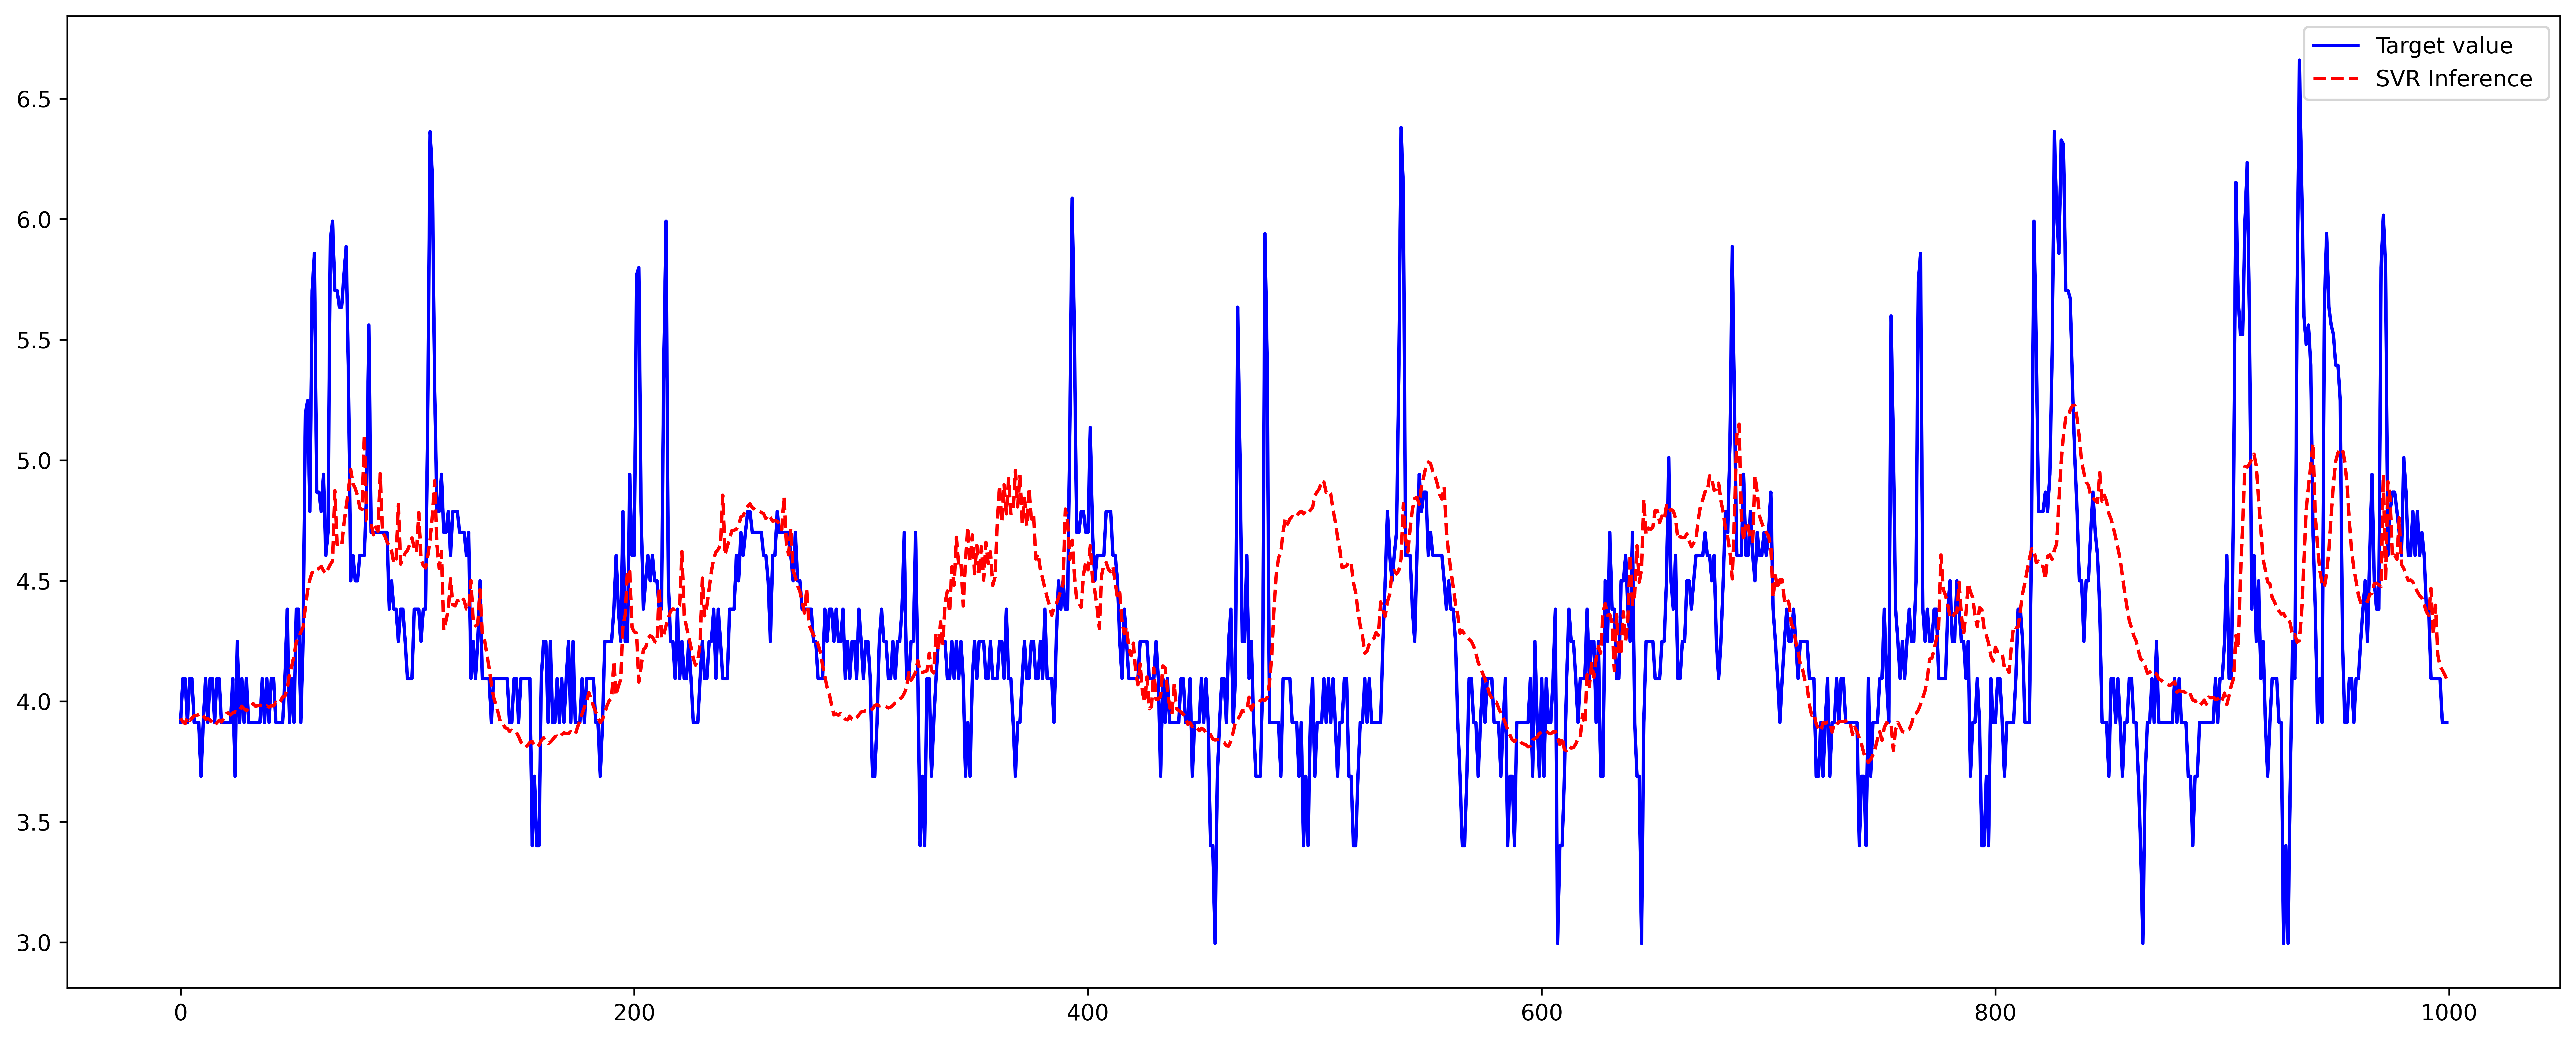

In [35]:
fig = plt.figure(figsize=(20,8), dpi=600)
plt.plot(y_test[:1000].values,label='Target value',color='b')
plt.plot(y_predicted_svr[:1000],label='SVR Inference ', linestyle='--', color='r')
plt.legend(loc=1)
plt.savefig("inference_graph.png")

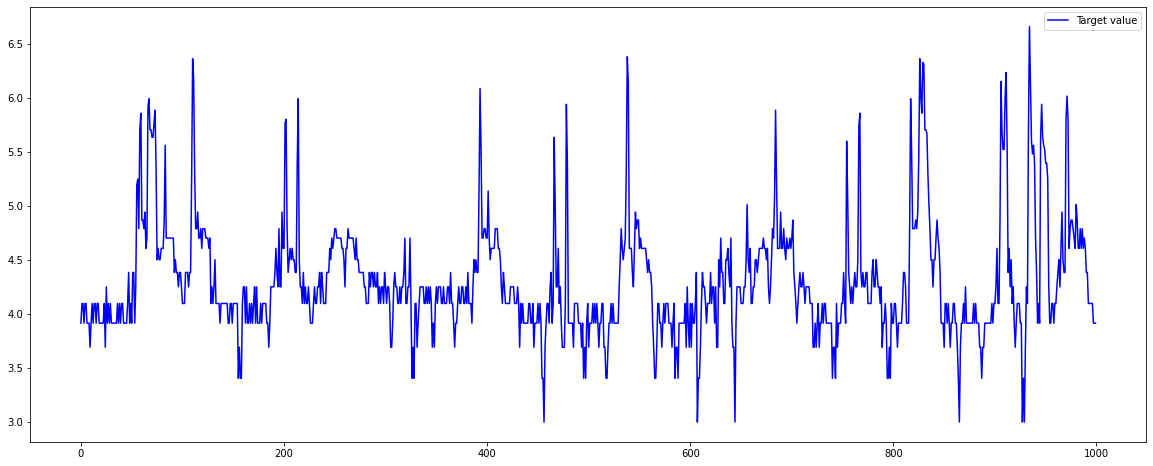

In [19]:
fig = plt.figure(figsize=(20,8))
plt.plot(y_test[:1000].values,label='Target value',color='b')
plt.legend(loc=1)

In [20]:
#from appliance_optimizer import make_grid

#grid = make_grid(X_test.iloc[0], controllable_parameters=features_config['optimization_features'])

#predictions_svr = svr_model.predict(grid)
#predictions_svr

In [21]:
from appliance_optimizer import ApplianceOptimizer


In [22]:
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

def compute_optimized_appliances(
        X,
        model
    ) -> pd.Series:
    """
    Compute optimized ROP for a given frequency.

    """
    live_predictor = ApplianceOptimizer(model, features_config)
    # Get optimized params and rop
    y_opt = X.progress_apply(live_predictor.optimize_appliance, axis="columns")

    return y_opt

In [23]:
X_test

,lights,T_out,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T4,T5,T6,T7,...,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out,T1,T2,T3
0,-0.523468,0.804817,0.190821,0.268545,0.097102,0.421644,1.492256,1.604677,0.488072,1.276463,...,-0.953786,0.610140,-1.032540,-0.582062,0.357029,-0.701800,-0.838210,1.186641,0.481733,2.165053
1,-0.523468,0.745524,0.190821,0.268545,-0.073864,0.491151,1.492256,1.604677,0.418031,1.258516,...,-0.946380,0.565005,-0.880551,-0.582062,0.446869,-0.670570,-0.632237,1.186641,0.481733,2.165053
2,-0.523468,0.686231,0.190821,0.268545,-0.244829,0.560657,1.492256,1.604677,0.369003,1.258516,...,-0.946380,0.512839,-0.725065,-0.565044,0.484197,-0.636809,-0.426264,1.186641,0.416350,2.209256
3,-0.523468,0.626939,0.190821,0.268545,-0.415794,0.630163,1.492256,1.604677,0.325578,1.258516,...,-0.925172,0.483982,-0.595030,-0.562208,0.509505,-0.559157,-0.220291,1.105807,0.416350,2.255669
4,-0.523468,0.567646,0.190821,0.268545,-0.586760,0.699670,1.492256,1.576596,0.290557,1.258516,...,-0.914803,0.450685,-0.507818,-0.549445,0.584794,-0.543964,-0.014318,1.159697,0.377121,2.255669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,-0.523468,3.990805,-0.034312,-0.371842,-1.191714,2.933144,2.999182,3.289532,3.912352,3.142975,...,1.501989,0.088488,-2.300316,1.820229,1.328320,1.279161,-2.022554,3.584719,4.077794,3.763004
5001,-0.523468,3.959183,-0.034312,-0.307803,-1.125959,2.923876,2.999182,3.312507,3.786279,3.178869,...,1.501989,0.080348,-2.300316,1.803212,1.274416,1.279161,-1.996807,3.530830,3.988873,3.718801
5002,0.652121,3.927560,-0.034312,-0.243764,-1.060203,2.914609,2.999182,3.312507,3.666510,3.168101,...,1.534980,0.073689,-2.300316,1.800376,1.249741,1.279161,-1.971061,3.530830,3.906864,3.663547
5003,0.652121,3.895937,-0.034312,-0.179726,-0.994447,2.905341,2.999182,3.289532,3.415765,3.142975,...,1.549118,0.066290,-2.300316,1.779671,1.222931,1.286124,-1.945314,3.530830,3.766571,3.557459


In [24]:
X_train

,lights,T_out,Press_mm_hg,Windspeed,Visibility,Tdewpoint,T4,T5,T6,T7,...,RH_4,RH_5,RH_6,RH_7,RH_8,RH_9,RH_out,T1,T2,T3
0,3.003298,0.164457,-2.748417,1.037009,1.911966,0.699670,-0.719206,-1.331054,0.178493,-1.442542,...,1.496491,0.399260,0.712553,1.249768,1.105490,0.960114,0.783827,-1.003962,-0.296323,-1.150200
1,3.003298,0.136787,-2.735909,0.908932,1.609488,0.671867,-0.719206,-1.331054,0.137869,-1.442542,...,1.596837,0.399260,0.705557,1.236532,1.098530,0.967710,0.783827,-1.003962,-0.296323,-1.150200
2,3.003298,0.109117,-2.723402,0.780855,1.307011,0.644065,-0.767045,-1.331054,0.080436,-1.442542,...,1.572683,0.387051,0.672747,1.211384,1.073223,0.952517,0.783827,-1.003962,-0.296323,-1.150200
3,4.178887,0.081447,-2.710895,0.652777,1.004534,0.616262,-0.790965,-1.331054,0.053821,-1.484418,...,1.533409,0.387051,0.682397,1.182927,1.046651,0.927196,0.783827,-1.003962,-0.296323,-1.150200
4,4.178887,0.053777,-2.698387,0.524700,0.702056,0.588460,-0.790965,-1.305526,0.039812,-1.442542,...,1.487850,0.387051,0.735593,1.171015,1.046651,0.927196,0.783827,-1.003962,-0.296323,-1.150200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14725,-0.523468,0.943166,0.180398,0.268545,-0.626213,0.676501,1.564015,1.681262,0.767533,1.321331,...,-0.946380,1.283480,-1.554849,-0.606453,0.142550,-0.863855,-0.709477,1.267475,0.640832,2.231358
14726,-0.523468,0.915496,0.182483,0.268545,-0.481550,0.625530,1.564015,1.681262,0.747222,1.294410,...,-0.946380,1.098496,-1.539288,-0.603901,0.168490,-0.828405,-0.735223,1.267475,0.619037,2.231358
14727,-0.523468,0.887826,0.184567,0.268545,-0.336887,0.574558,1.549663,1.681262,0.705197,1.258516,...,-0.951564,0.913513,-1.466913,-0.603901,0.206451,-0.787892,-0.760970,1.267475,0.619037,2.231358
14728,-0.523468,0.860156,0.186652,0.268545,-0.192224,0.523587,1.523010,1.604677,0.642161,1.267489,...,-0.961192,0.771816,-1.324454,-0.600781,0.263392,-0.754130,-0.786716,1.213586,0.553654,2.187154


In [25]:
y_opt = compute_optimized_appliances(X_test, svr_model)
y_opt.index = y_test.index

  0%|          | 0/5005 [00:00<?, ?it/s]

/Users/guillaumedelepoulle/Library/Caches/pypoetry/virtualenvs/metric-article-SLF5aoAh-py3.9/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
y_opt.to_csv("y_opt_svr.csv")

In [ ]:
y_opt

In [ ]:
from typing import Tuple
from sklearn.metrics import mean_squared_error


def compute_rop_gains(
        y_pred: pd.Series,
        y_true: pd.Series,
        y_opt : pd.Series
    ) -> Tuple[pd.Series, pd.Series]:


    gains = (y_opt / y_true).mean()

    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    gain_error = rmse / y_true.mean()
    return gains, gain_error

In [ ]:
compute_rop_gains(y_predicted_svr, y_test, y_opt)

In [ ]:
%pip install prophet


In [ ]:
from prophet import Prophet


In [ ]:
X_test

In [ ]:
X_fit_prophet = X_train
X_fit_prophet['y'] = y_train.copy()
X_fit_prophet_i = X_fit_prophet.reset_index()
X_fit_prophet_i= X_fit_prophet_i.rename(columns={"date":"ds"})

In [ ]:
X_fit_prophet_i

In [ ]:
m = Prophet()

for feature_name in (features_config['features_to_normalize'] + features_config['raw_features']):
    m.add_regressor(feature_name)

m.fit(X_fit_prophet_i)

In [ ]:
X_test_fit = X_test.reset_index().rename(columns={"date":"ds"})

Trying Prophet

In [ ]:
y_hat  = m.predict(X_test_fit)

In [ ]:
y_pred = y_hat["yhat"]

In [ ]:
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 =  metrics.r2_score(y_test, y_pred)

print(f"R2 profet = {r2}")
print(f"mae profet = {mae}")

In [ ]:
X_test_fit['lights'].iloc[0] = 42
X_test_fit

In [ ]:
y_hat["yhat"]

In [ ]:
3.973754